## Imports

In [1]:
import unicodedata  
import inflect       
import re
from nltk import sent_tokenize
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
import collections

## Step 1: Text pre-processing

### 1.1 Text Combination and Train_valid_test Split

In [2]:
fake_news_df = pd.read_csv('Data/Fake.csv')
true_news_df = pd.read_csv('Data/True.csv')
fake_news_df['label'] = 'False'
true_news_df['label'] = 'True'
news_df = pd.concat([fake_news_df, true_news_df], ignore_index=True, axis=0)
print(news_df.shape)
print(news_df.columns)
print(news_df.info())


(44898, 5)
Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB
None


In [3]:
news_df = news_df[news_df.text.isna() == False]
news_df = news_df[news_df.title.isna() == False]
news_df = news_df[news_df.subject.isna() == False]
print(news_df.shape)

(44898, 5)


In [4]:
news_df['text'] = news_df['title'] + ' ' + news_df['text'] + ' ' + news_df['subject']
news_df.drop(['title', 'date', 'subject'], axis=1, inplace=True)
print(news_df.head())
print(news_df.label.value_counts())

                                                text  label
0   Donald Trump Sends Out Embarrassing New Year’...  False
1   Drunk Bragging Trump Staffer Started Russian ...  False
2   Sheriff David Clarke Becomes An Internet Joke...  False
3   Trump Is So Obsessed He Even Has Obama’s Name...  False
4   Pope Francis Just Called Out Donald Trump Dur...  False
label
False    23481
True     21417
Name: count, dtype: int64


In [5]:
by_labels = collections.defaultdict(list)
for _, row in news_df.iterrows():
    by_labels[row.label].append(row.to_dict())

In [6]:
# split dateset to train, validate and test dataset and stored in list
final_list = []
np.random.seed(1234)

for _, item_list in sorted(by_labels.items()):

    np.random.shuffle(item_list)
    
    n_total = len(item_list)
    n_train = int(0.7 * n_total)
    n_valid = int(0.15 * n_total)
    n_test = n_total - n_train - n_valid
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_valid]:
        item['split'] = 'val'
    for item in item_list[n_train+n_valid:]:
        item['split'] = 'test'

    # Add to final list
    final_list.extend(item_list) 

In [7]:
final_df = pd.DataFrame(final_list)
final_df.split.value_counts()

split
train    31427
test      6737
val       6734
Name: count, dtype: int64

### 1.2 Data preprocessing

In [8]:
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas


def preprocess_text(text):
    if type(text) == float:
        print(text)
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)  # E.g., convert "end." to "end . " ; \1 indicates a matched character
    text = re.sub(r"[^a-zA-Z0-9]+", r" ", text) # replace special characters with empty string
    return text.strip()

In [9]:
final_df['text'] = final_df['text'].apply(preprocess_text)
final_df.head()

,text,label,split
0,jake tapper burns trump with bill maher he is ...,False,train
1,buried by media aide to leftist us congressman...,False,train
2,cnn clown who cries about fake news uses unver...,False,train
3,delusional obama on how divided america has be...,False,train
4,veterans cozy trump relationship with russian ...,False,train


In [10]:
final_df['text'] = final_df['text'].apply(word_tokenize)
final_df.head()

,text,label,split
0,"[jake, tapper, burns, trump, with, bill, maher...",False,train
1,"[buried, by, media, aide, to, leftist, us, con...",False,train
2,"[cnn, clown, who, cries, about, fake, news, us...",False,train
3,"[delusional, obama, on, how, divided, america,...",False,train
4,"[veterans, cozy, trump, relationship, with, ru...",False,train


In [11]:
final_df['text'] = final_df['text'].apply(remove_stopwords)
final_df.head()

,text,label,split
0,"[jake, tapper, burns, trump, bill, maher, empi...",False,train
1,"[buried, media, aide, leftist, us, congressman...",False,train
2,"[cnn, clown, cries, fake, news, uses, unverifi...",False,train
3,"[delusional, obama, divided, america, become, ...",False,train
4,"[veterans, cozy, trump, relationship, russian,...",False,train


In [12]:
final_df['text'] = final_df['text'].apply(stem_words)
final_df['text'] = final_df['text'].apply(lemmatize_verbs)
final_df.head()

,text,label,split
0,"[jak, tap, burn, trump, bil, mah, empir, indec...",False,train
1,"[bury, med, aid, leave, us, congressm, sand, l...",False,train
2,"[cnn, clown, cri, fak, new, us, unver, story, ...",False,train
3,"[delud, obam, divid, americ, becom, least, civ...",False,train
4,"[vet, cozy, trump, rel, russ, hack, caus, alar...",False,train


In [16]:
final_df['text'] = final_df['text'].apply(lambda x: ' '.join(x))

In [17]:
final_df.to_csv('Data/preprocessed_news.csv', index=False)

In [18]:
final_df['word_length'] = final_df['text'].apply(lambda x: len(x.split()))
final_df['word_length'].mean()

250.4421132344425

# LSTM Model

In [19]:
from argparse import Namespace
import os
import json
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

## Vocabulary, Vectorizer, Dataset

In [20]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """    

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx         
                                                  
        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [21]:
class NewsVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(NewsVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token  # for paddding, e.g., 'McMahan' -> [2, 5, 6, 5, 7, 8, 7, 9, 3, 0, 0, 0, ..., 0]
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)           # mask_index is 0
        self.unk_index = self.add_token(self._unk_token)             # unk_index is 1
        self.begin_seq_index = self.add_token(self._begin_seq_token) # begin_seq_index is 2
        self.end_seq_index = self.add_token(self._end_seq_token)     # end_seq_index is 3

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [22]:
class NewsVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""   
    def __init__(self, news_vocab, label_vocab):
        """
        Args:
            news_vocab (NewsVocabulary): maps words to integers
            label_vocab (Vocabulary): maps labels to integers
        """
        self.news_vocab = news_vocab
        self.label_vocab = label_vocab

    def vectorize(self, news, vector_length=-1):
        """
        Args:
            news (str): the string of words
            vector_length (int): an argument for forcing the length of index vector
        """        
        # Split text into words and limit the number of words
        words = str(news).split(" ")
        
        # If vector_length is specified and positive, truncate words to fit
        if vector_length > 0:
            max_words = vector_length - 2  # Reserve space for begin and end tokens
            words = words[:max_words]
        
        indices = [self.news_vocab.begin_seq_index]
        indices.extend(self.news_vocab.lookup_token(token) 
                       for token in words)
        indices.append(self.news_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)   # Fixed size vector
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.news_vocab.mask_index
        
        return out_vector, len(indices)

    @classmethod
    def from_dataframe(cls, news_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            news_df (pandas.DataFrame): the news dataset
        Returns:
            an instance of the NewsVectorizer
        """
        news_vocab = NewsVocabulary() # add mask, unknown, begin_seq, and end_seq tokens to the token_to_index dictionary
        label_vocab = Vocabulary()
        
        for index, row in news_df.iterrows():
            for word in str(row.text).split(" "):
                news_vocab.add_token(word)
            label_vocab.add_token(row.label)

        return cls(news_vocab, label_vocab)

In [23]:
class NewsDataset(Dataset):
    def __init__(self, news_df, vectorizer, max_seq_length=512):
        """
        Args:
            news_df (pandas.DataFrame): the dataset
            vectorizer (NewsVectorizer): vectorizer instatiated from dataset
            max_seq_length (int): maximum sequence length to prevent memory issues
        """
        self.news_df = news_df 
        self._vectorizer = vectorizer

        # Use the specified max_seq_length directly
        self._max_seq_length = max_seq_length

        self.train_df = self.news_df[self.news_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.news_df[self.news_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.news_df[self.news_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size), 
                             'val': (self.val_df, self.validation_size), 
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # Class weights for binary classification
        class_counts = self.train_df.label.value_counts().to_dict()   # {'False': count1, 'True': count2}
        def sort_key(item):
            return self._vectorizer.label_vocab.lookup_token(item[0]) # e.g, index of False is 0, True is 1
        sorted_counts = sorted(class_counts.items(), key=sort_key)          # sort by the index number of label_vocab
                                   # {('False', count1), ('True', count2)}
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32) # [1/count1, 1/count2]

        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, news_csv, max_seq_length=512):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            news_csv (str): location of the dataset
            max_seq_length (int): maximum sequence length to prevent memory issues
        Returns:
            an instance of NewsDataset
        """
        news_df = pd.read_csv(news_csv)
        train_news_df = news_df[news_df.split=='train']
        return cls(news_df, NewsVectorizer.from_dataframe(train_news_df), max_seq_length)
        
    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's:
                features (x_data)
                label (y_target)
                feature length (x_length)
        """
        row = self._target_df.iloc[index]
        
        news_vector, vec_length = \
            self._vectorizer.vectorize(row.text, self._max_seq_length)
        
        label_index = \
            self._vectorizer.label_vocab.lookup_token(row.label)

        return {'x_data': news_vector,      # 'x_data': [2, 5, 6, 5, 7, 8, 7, 9, 3, 0, 0, 0, ..., 0] when news is processed
                'y_target': label_index, # 'y_target': 0 for False, 1 for True              
                'x_length': vec_length}        # 'x_length': sequence length
    
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size   

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## Model

In [24]:

def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1   # deduct 1 since the index starts from 0
                                                              # e.g., [9, 6, 11, 9, 7, ...., 12]
    out = []
    for batch_index, column_index in enumerate(x_lengths): # out gets the last hidden vector of each input: (batch, hidden_size)
        out.append(y_out[batch_index, column_index]) # e.g., y_out[0, 9], y_out[1, 6]

    return torch.stack(out)  # (batch, hidden_size*num_directions); E.g., (64, 64*num_direction)

def column_summation(y_out, x_lengths, mode="mean"):
    '''Get a max or mean vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the max or mean vector of all the vectors by 
    the position indicated by the corresponding value in `x_lengths` at the row index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)
        mode: "mean" for mean vector; "max" for max vector

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        if mode == "mean":
            # replace "pass" with your code to get the mean vector of current batch item from y_out[], and append it to out list.
            out.append(y_out[batch_index, :column_index + 1].mean(dim=0))
        else:      # mode == "max"
            # replace "pass" with your code to get the max vector of current batch item from y_out[], , and append it to out list.
            out.append(y_out[batch_index, :column_index + 1].max(dim=0).values)

    return torch.stack(out)

class NewsClassifier(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, bidirectional=False, batch_first=True, padding_idx=0):
        """
        Args:
            embedding_size (int): The size of the character embeddings
            num_embeddings (int): The number of characters to embed
            num_classes (int): The size of the prediction vector 
                Note: For binary classification, this should be 1
            bidirectional (bool): Informs whether bidrectional RNN is used
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Informs whether the input tensors will 
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding; 
                see torch.nn.Embedding
        """
        super(NewsClassifier, self).__init__()

        if bidirectional == False:
             self.num_directions = 1
        else:
             self.num_directions = 2
        
        self.emb = nn.Embedding(num_embeddings=num_embeddings,    # E.g., (80, 100)
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)          # mask_index (padding index) is 0

        #self.rnn = nn.RNN(input_size=embedding_size,              # E.g., 100
        #self.rnn = nn.GRU(input_size=embedding_size,
        self.rnn = nn.LSTM(input_size=embedding_size,
                             hidden_size=rnn_hidden_size,         # E.g., 64
                             batch_first=batch_first, 
                             num_layers = 1,
                             dropout = 0.0, 
                             bidirectional=bidirectional)
        
        self.fc1 = nn.Linear(in_features=rnn_hidden_size*self.num_directions,  # 64*1 for unidirectinal; 64*2 for bidirectional
                         out_features=rnn_hidden_size*self.num_directions)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size*self.num_directions,
                          out_features=1)                            # 1 output for binary classification
        # for batch norm & dropout
        self.bn1 = nn.BatchNorm1d(rnn_hidden_size*self.num_directions) 
        self.dropout = nn.Dropout(0.2)


    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim, i.e. seq_size)
            x_lengths (torch.Tensor): the lengths of each sequence in the batch.
                They are used to find the final vector of each sequence: (batch,)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, 1) for binary classification
        """
        x_embedded = self.emb(x_in)      # (batch, seq_size)->(batch, seq_size, feat_size) ; E.g., (64,19)->(64,19,100)
        
        y_out, _ = self.rnn(x_embedded)  # (batch, seq_size, feat_size) -> (batch, seq_size, hidden_size*num_directions)
                                         # (64,19,100) -> (64,19,64*num_directions)
      
        if x_lengths is not None:        # (batch, ) ; e.g., (64,) ; e.g., [9, 6, 11, 9, 7, ...., 12]
            #y_out = column_gather(y_out, x_lengths)  # y_out gets the last hidden vector of each input: (batch, hidden_size*num_directions)
                                                     # (64, 64*num_direction)
                                                     # but, the last hidden vector of last character, not including padding
                                                     # e.g., get the last hidden vetor from y_out[batch_no, 9] instead of y_out[batch_no, 18].

            # uncomment code below for task 2, and comment out the line above.
            # y_out gets the max or mean hidden vector of each input
            y_out = column_summation(y_out, x_lengths, mode="mean") 
        else:
            y_out = y_out[:, -1, :]      # y_out gets the last hidden vector of each input: (batch, hidden_size*num_directions)
                                         # (64, 64*num_direction)
            
        # with batch norm and dropout
        # F.dropout(y_out, 0.2, training=self.training) can also be used as an alternative to self.dropout(y_out) 
        y_out = F.relu(self.bn1(self.fc1(self.dropout(y_out))))  # y_out: (64, 64*num_direction)

        
        # with dropout
        y_out = self.fc2(self.dropout(y_out))   # y_out: (batch, 1) for binary classification

        if apply_softmax:
            y_out = torch.sigmoid(y_out)  # Use sigmoid for binary classification instead of softmax

        return y_out

In [25]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

## Settings

In [26]:
args = Namespace(
    # Data and path information
    output_news_csv='Data/preprocessed_news.csv',
    model_state_file="model.pth",
    save_dir="model_storage/ch6/news_classification",
    # Model hyper parameter
    char_embedding_size=100,
    rnn_hidden_size=64,
    bidirectional=False,
    # Training hyper parameter
    num_epochs=100,  # Reduced from 100 to 10 for testing
    learning_rate=1e-3,
    batch_size=64,  # Reduced from 64 to 32 to save memory
    seed=1337,
    early_stopping_criteria=5,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
    expand_filepaths_to_save_dir=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)
    
# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Using CUDA: False


In [28]:
# create dataset and vectorizer with limited sequence length
dataset = NewsDataset.load_dataset_and_make_vectorizer(args.output_news_csv, max_seq_length=512)

vectorizer = dataset.get_vectorizer()

classifier = NewsClassifier(embedding_size=args.char_embedding_size, 
                               num_embeddings=len(vectorizer.news_vocab),
                               num_classes=1,  # Binary classification
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.news_vocab.mask_index,
                               bidirectional=args.bidirectional)

In [29]:
# Test data loading to ensure everything works
print("Testing data loading...")
dataset.set_split('train')

# Test vectorization with a long text
test_text = "This is a very long text that should be truncated properly when we vectorize it. " * 100
print(f"Original text length: {len(test_text.split())} words")

vectorized, length = dataset._vectorizer.vectorize(test_text, dataset._max_seq_length)
print(f"Vectorized length: {length}")
print(f"Vector shape: {vectorized.shape}")
print(f"Max sequence length: {dataset._max_seq_length}")

# Test batch loading
test_batch = next(iter(generate_batches(dataset, batch_size=2, device=args.device)))
print(f"Batch shape: {test_batch['x_data'].shape}")
print(f"Target shape: {test_batch['y_target'].shape}")
print(f"Length shape: {test_batch['x_length'].shape}")
print("Data loading test passed!")


Testing data loading...
Original text length: 1500 words
Vectorized length: 512
Vector shape: (512,)
Max sequence length: 512
Batch shape: torch.Size([2, 512])
Target shape: torch.Size([2])
Length shape: torch.Size([2])
Data loading test passed!


In [30]:
dataset._max_seq_length # max sequence length

512

In [31]:
vectorizer.news_vocab._token_to_idx

{'<MASK>': 0,
 '<UNK>': 1,
 '<BEGIN>': 2,
 '<END>': 3,
 'jak': 4,
 'tap': 5,
 'burn': 6,
 'trump': 7,
 'bil': 8,
 'mah': 9,
 'empir': 10,
 'indec': 11,
 'video': 12,
 'lot': 13,
 'americ': 14,
 'chang': 15,
 'sint': 16,
 'ris': 17,
 'donald': 18,
 'peopl': 19,
 'think': 20,
 'coars': 21,
 'langu': 22,
 'clear': 23,
 'rac': 24,
 'misogyny': 25,
 'gen': 26,
 'appal': 27,
 'behavy': 28,
 'would': 29,
 'rend': 30,
 'unacceiv': 31,
 'be': 32,
 'publ': 33,
 'yet': 34,
 'presid': 35,
 'young': 36,
 'admin': 37,
 'funda': 38,
 'world': 39,
 'view': 40,
 'cit': 41,
 'govern': 42,
 'on': 43,
 'thing': 44,
 'though': 45,
 'way': 46,
 'strident': 47,
 'brav': 48,
 'med': 49,
 'person': 50,
 'continu': 51,
 'speak': 52,
 'tru': 53,
 'pow': 54,
 'insist': 55,
 'mak': 56,
 'sur': 57,
 'disgust': 58,
 'incompet': 59,
 'lie': 60,
 'perhap': 61,
 'breakout': 62,
 'star': 63,
 'regard': 64,
 'cnn': 65,
 'host': 66,
 'lead': 67,
 'week': 68,
 'stat': 69,
 'un': 70,
 'sunday': 71,
 'morn': 72,
 'friday': 7

In [32]:
vectorizer.label_vocab._token_to_idx

{False: 0, True: 1}

## Training Routine

In [33]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}


def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        #if loss_t >= loss_tm1: # if current loss becomes smaller than the previous loss, early_stopping_step is reset to 0.
                                # this statement makes the model training time longer, compared to the statement below. 
        if loss_t >= train_state['early_stopping_best_val']:  # curent loss is compared with early_stopping_best_val loss value
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state


def compute_accuracy(y_pred, y_target, threshold=0.5):

    """Compute accuracy for binary classification"""

    # Convert predictions to probabilities using sigmoid
    y_prob = torch.sigmoid(y_pred)
    # Convert probabilities to binary predictions
    y_pred_class = (y_prob > threshold).float()
    # Ensure targets are float for comparison
    y_target_float = y_target.float()
    # Calculate accuracy
    correct = (y_pred_class == y_target_float).sum().item()
    total = y_target_float.size(0)
    return correct / total * 100

In [34]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=10)

train_state = make_train_state(args)

# Print dataset info for debugging
print(f"Dataset info:")
print(f"  Train size: {dataset.train_size}")
print(f"  Val size: {dataset.validation_size}")
print(f"  Test size: {dataset.test_size}")
print(f"  Max sequence length: {dataset._max_seq_length}")
print(f"  Batch size: {args.batch_size}")
print(f"  Train batches: {dataset.get_num_batches(args.batch_size)}")

epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

try:

    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                        x_lengths=batch_dict['x_length'])

            # 2. 修正 Target 形状并计算 Loss (使用前面建议的修正)
            y_target = batch_dict['y_target'].float().unsqueeze(1) 
            loss = loss_func(y_pred, y_target) 
    
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, y_target)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        with torch.no_grad():  # Disable gradient computation
          for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                        x_lengths=batch_dict['x_length'])

            # 2. 修正 Target 形状并计算 Loss (使用前面建议的修正)
            y_target = batch_dict['y_target'].float().unsqueeze(1) 
            loss = loss_func(y_pred, y_target) 
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, y_target)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        train_bar.reset()
        val_bar.reset()
        epoch_bar.update()

        if train_state['stop_early']:
            break
            
except KeyboardInterrupt:
    print("Exiting loop")

Dataset info:
  Train size: 31427
  Val size: 6734
  Test size: 6737
  Max sequence length: 512
  Batch size: 64
  Train batches: 491


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/491 [00:00<?, ?it/s]

split=val:   0%|          | 0/105 [00:00<?, ?it/s]

In [35]:
import plotly.graph_objects as go

acc = train_state['train_acc']
val_acc = train_state['val_acc']
loss = train_state['train_loss']
val_loss = train_state['val_loss']

epochs = list(range(1, len(acc) + 1))

# Create interactive line chart
fig = go.Figure()

for y, name, color, mode in [(loss, 'Training Loss', 'blue', 'lines+markers'),
                             (val_loss, 'Validation Loss', 'royalblue', 'lines')]:
    fig.add_trace(go.Scatter(x=epochs, y=y, mode=mode, name=name, line=dict(color=color)))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis_title='Epochs',
    yaxis_title='Loss',
    legend=dict(x=0.02, y=0.98)
)

fig.show()

In [36]:
# Create interactive line chart for accuracy
fig = go.Figure()

for y, name, color, mode in [(acc, 'Training Accuracy', 'blue', 'lines+markers'),
                             (val_acc, 'Validation Accuracy', 'royalblue', 'lines')]:
    fig.add_trace(go.Scatter(x=epochs, y=y, mode=mode, name=name, line=dict(color=color)))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis_title='Epochs',
    yaxis_title='Accuracy',
    legend=dict(x=0.02, y=0.98)
)

fig.show()

In [37]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename'],weights_only=False))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.BCEWithLogitsLoss()

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

y_pred_list = []         # store predicted values for confusion matrix
y_true_list = []        # ground truth values

with torch.no_grad():  # Disable gradient computation
  for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'],
                         x_lengths=batch_dict['x_length'])

    # store predicted values and ground truth values for calculating confusion matrix
    y_pred_prob = torch.sigmoid(y_pred).squeeze()
    y_pred_binary = (y_pred_prob > 0.5).float()
    y_pred_list.extend(y_pred_binary.cpu().numpy())
    y_target = batch_dict['y_target'].float().unsqueeze(1)
    y_true_list.extend(y_target.cpu().numpy())
    
    # compute the loss
    loss = loss_func(y_pred, y_target) 
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, y_target)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [38]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 0.014516954756583707;
Test Accuracy: 99.74702380952381


In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# For binary classification, we have two classes: False (0) and True (1)
binary_classes = ['False', 'True']
print("Binary classes:", binary_classes)

Binary classes: ['False', 'True']


In [40]:
import pandas as pd
cm = confusion_matrix(y_true_list, y_pred_list)
cm_df = pd.DataFrame(cm.T, index=binary_classes, columns=binary_classes)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True       False  True
Predicted             
False       3506     7
True          10  3197


In [41]:
print(classification_report(y_true_list, y_pred_list, target_names=binary_classes))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3516
        True       1.00      1.00      1.00      3204

    accuracy                           1.00      6720
   macro avg       1.00      1.00      1.00      6720
weighted avg       1.00      1.00      1.00      6720



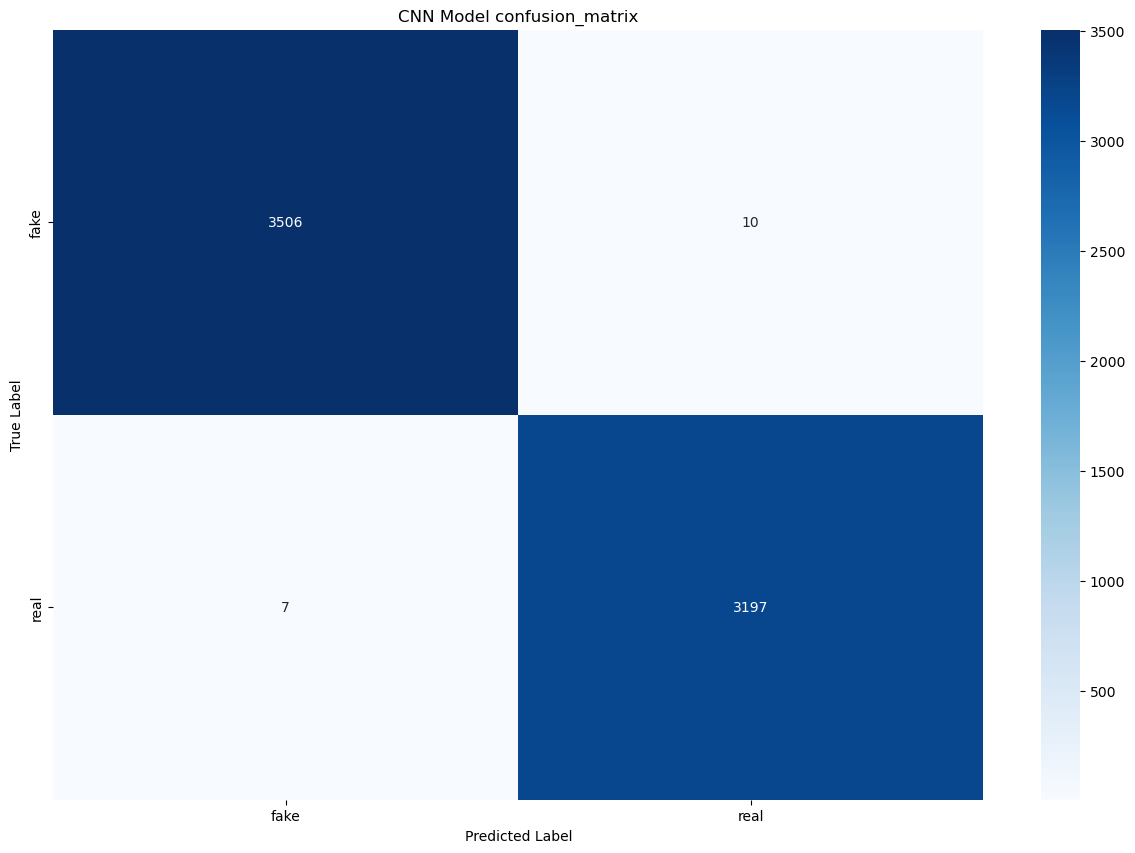

In [42]:
from matplotlib import pyplot as plt
import seaborn as sns
class_names = ['fake', 'real']
name = 'CNN Model'
cm = confusion_matrix(y_true_list, y_pred_list)
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
plt.title(f'{name} confusion_matrix', fontsize=12)
plt.ylabel('True Label', fontsize=10)
plt.xlabel('Predicted Label', fontsize=10)
plt.show()